In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.nn.parallel import DataParallel
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
import copy

In [2]:
# Check available devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    multi_gpu = True
else:
    print("Using single GPU")
    multi_gpu = False


Using device: cuda
Using 2 GPUs!


In [3]:
# Define batch size and other hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MOMENTUM = 0.9
STEP_SIZE = 7
GAMMA = 0.1
EPOCHS = 15


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalized for grayscale
])


In [5]:
# Set the path for the Kaggle dataset folders.
train_path = '/kaggle/input/devanagri-characters-and-numbers/DevanagariHandwrittenCharacterDataset/Train'
test_path  = '/kaggle/input/devanagri-characters-and-numbers/DevanagariHandwrittenCharacterDataset/Test'

In [6]:
# Load the training dataset twice: one for training and one for validation.
full_train_dataset = ImageFolder(root=train_path, transform=transform)
full_val_dataset   = ImageFolder(root=train_path, transform=transform)

In [9]:
# Import libraries needed for the project.
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [10]:
import numpy as np
# Create a random split: 80% for training and 20% for validation.
num_samples = len(full_train_dataset)
indices = np.arange(num_samples)
np.random.shuffle(indices)
split = int(0.85 * num_samples)
train_indices, val_indices = indices[:split], indices[split:]

train_subset = Subset(full_train_dataset, train_indices)
val_subset   = Subset(full_val_dataset, val_indices)

# Load the test dataset.
test_dataset = ImageFolder(root=test_path, transform=transform)

In [13]:
# Create data loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
print(f"Training dataset size: {len(train_subset)}")
print(f"Validation dataset size: {len(val_subset)}")


Training dataset size: 66470
Validation dataset size: 11730


In [14]:
# Load the pretrained VGG16 model
model = models.vgg16(pretrained=True)
print("VGG16 model loaded successfully")

# Modify first conv layer to accept grayscale input (1 channel instead of 3)
original_conv1 = model.features[0]
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

# Transfer weights from pretrained model to new conv layer by averaging
with torch.no_grad():
    new_weight = original_conv1.weight.data.mean(dim=1, keepdim=True)
    model.features[0].weight.data = new_weight

# Modify classifier for 46 Devanagari character classes
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 46)

# Move model to device
model = model.to(device)

# Use DataParallel for multi-GPU training
if multi_gpu:
    model = DataParallel(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s]  


VGG16 model loaded successfully


In [15]:
# Function to train one epoch
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples * 100
    
    return epoch_loss, epoch_acc.item()


In [17]:
# Function to validate the model
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples * 100
    
    return epoch_loss, epoch_acc.item()

In [18]:
# Lists to track progress
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_acc = 0.0

# Training loop
start_time = time.time()
best_model_wts = copy.deepcopy(model.state_dict())

In [19]:
print(f"Starting training for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    # Train and validate
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Step the scheduler
    scheduler.step()
    
    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # Record statistics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Print statistics
    print(f'Epoch {epoch+1}/{EPOCHS} | Time: {epoch_time:.0f}s')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    print('-' * 50)

total_time = time.time() - start_time
print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
print(f'Best Validation Accuracy: {best_acc:.2f}%')


Starting training for 15 epochs...
Epoch 1/15 | Time: 845s
Train Loss: 0.3422 | Train Acc: 90.29%
Val Loss: 0.0460 | Val Acc: 98.55%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 2/15 | Time: 850s
Train Loss: 0.0486 | Train Acc: 98.55%
Val Loss: 0.0283 | Val Acc: 99.24%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 3/15 | Time: 850s
Train Loss: 0.0253 | Train Acc: 99.23%
Val Loss: 0.0315 | Val Acc: 99.17%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 4/15 | Time: 850s
Train Loss: 0.0189 | Train Acc: 99.40%
Val Loss: 0.0256 | Val Acc: 99.34%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 5/15 | Time: 850s
Train Loss: 0.0150 | Train Acc: 99.54%
Val Loss: 0.0269 | Val Acc: 99.32%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 6/15 | Time: 850s
Train Loss: 0.0100 | Train Acc: 99.70%
Val Loss: 0.0307 | Val Acc: 99.25%
Le

In [20]:
# After training, save the best model and evaluate on test set
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'dhcd_vgg16_best_model.pth')
print(f'Best validation accuracy: {best_acc:.2f}%')

Best validation accuracy: 99.54%


In [22]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [23]:
# Evaluate on test set
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 99.57%


In [24]:
import shutil
shutil.move("dhcd_vgg16_best_model.pth", "/kaggle/working/dhcd_vgg16_best_model.pth")


'/kaggle/working/dhcd_vgg16_best_model.pth'

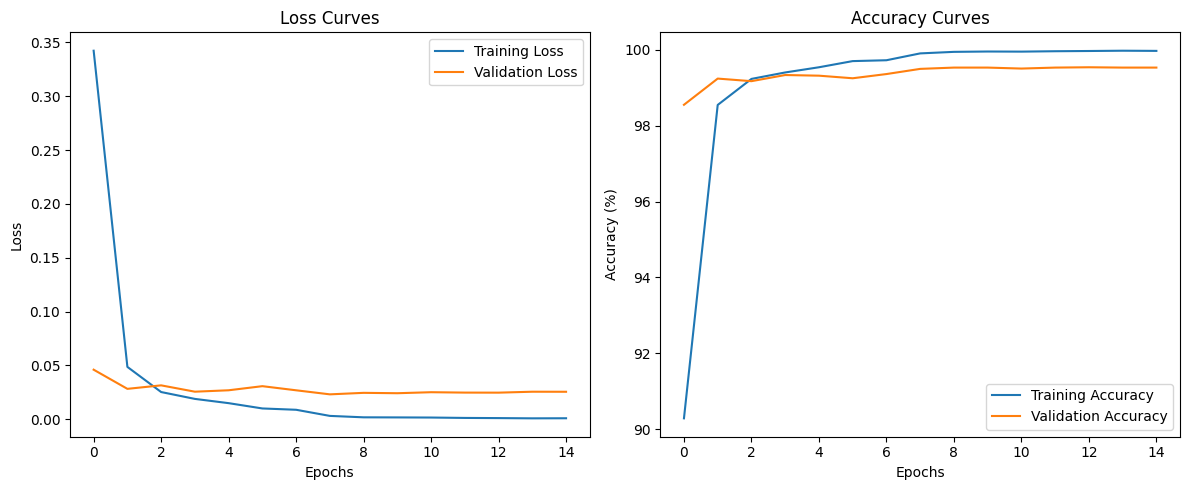

In [25]:
# Plot training curves
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')

Confusion matrix, without normalization


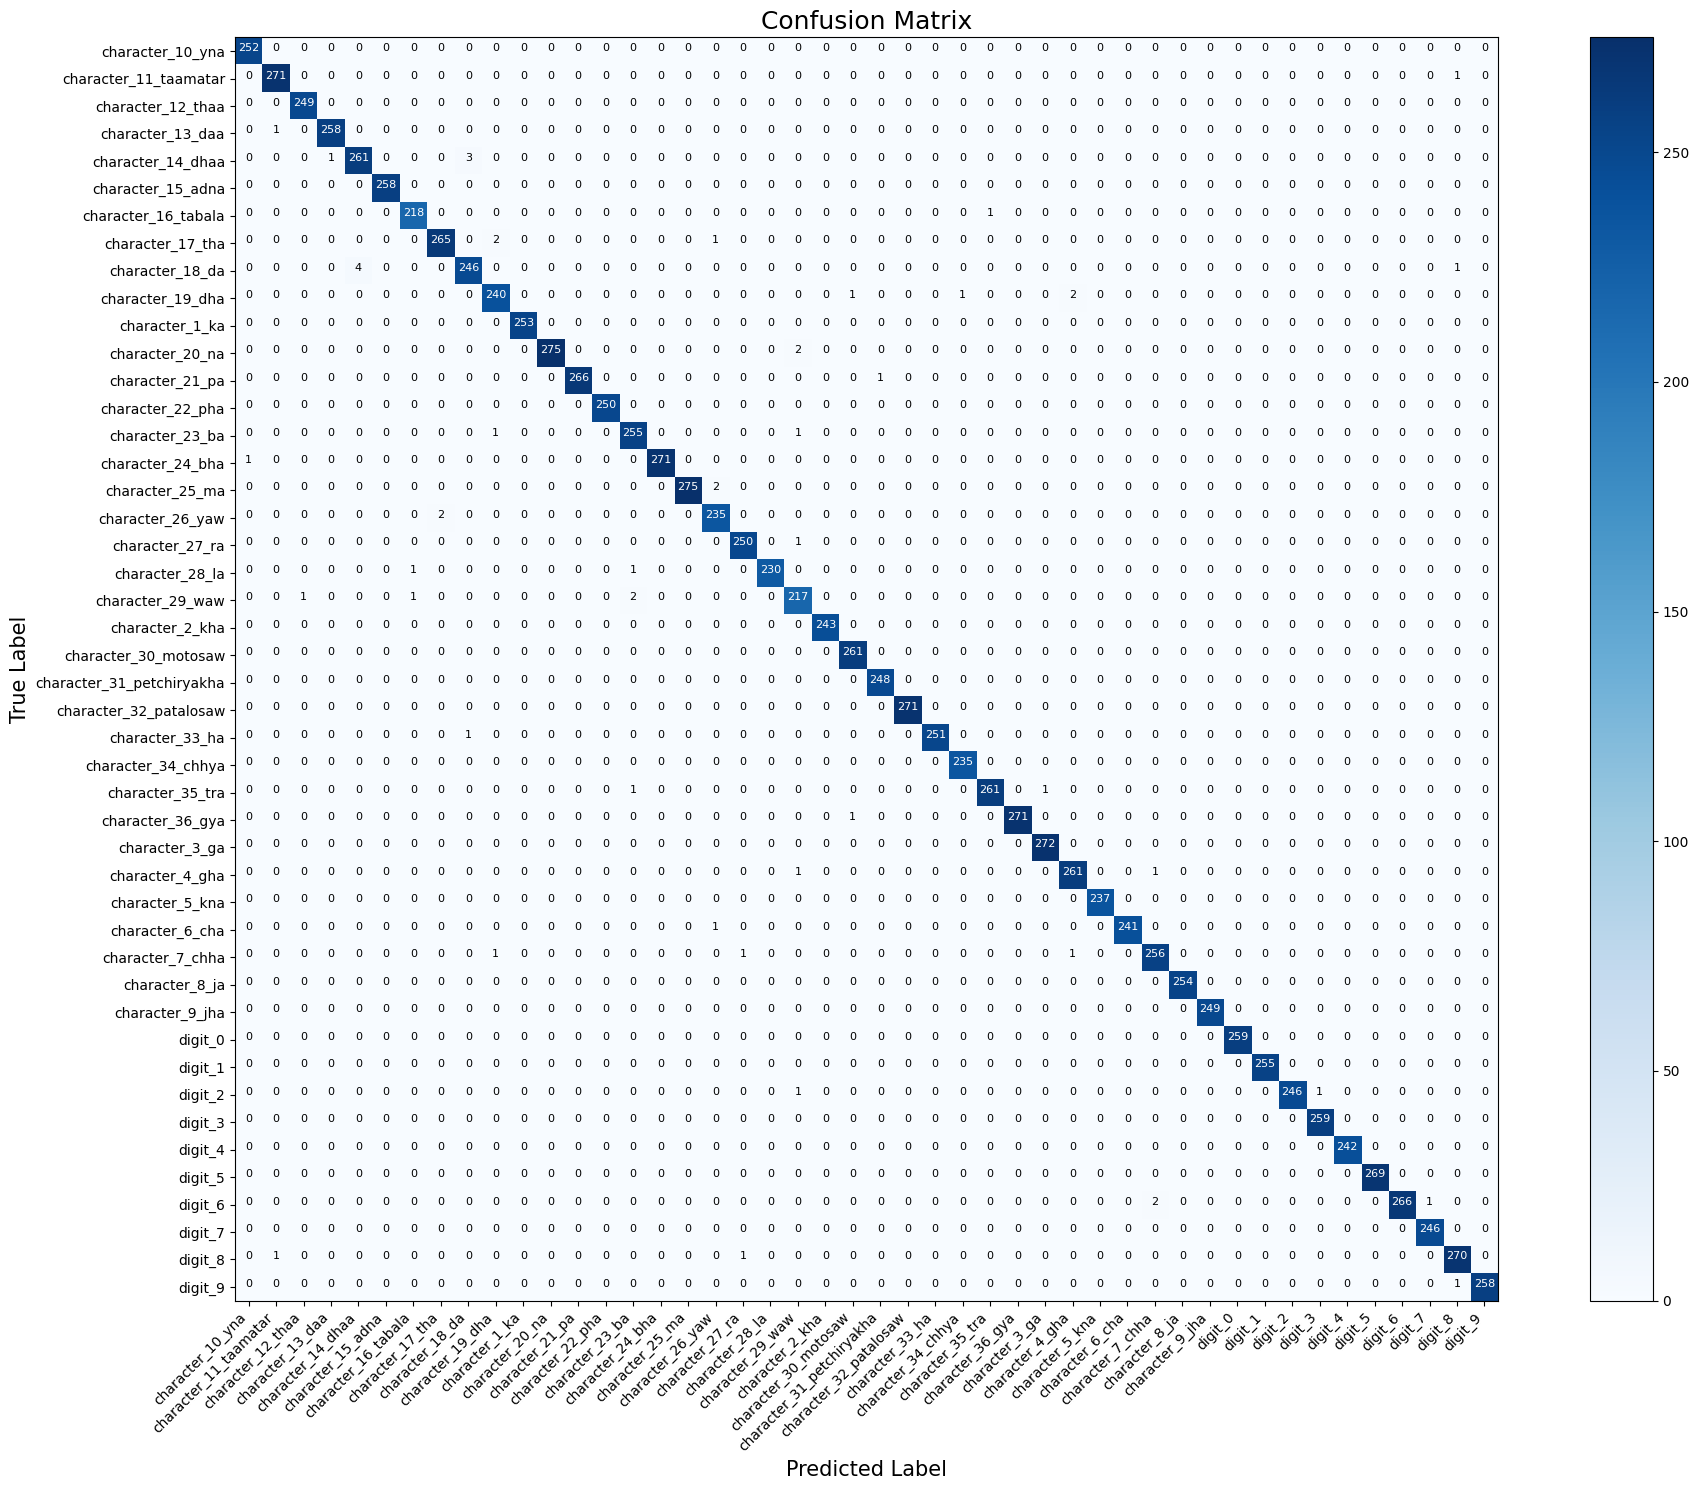

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

# Define the custom function to plot the confusion matrix
def plot_confusion_matrix(confusion_matrix, class_names=None, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot the confusion matrix with numbers in each cell.
    
    Args:
        confusion_matrix: confusion matrix to plot
        class_names: list of class names (if None, will use indices)
        normalize: Boolean, whether to normalize the confusion matrix
        title: title for the plot
        cmap: colormap to use
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        print("Normalized confusion matrix")
    else:
        fmt = '.0f' if np.issubdtype(confusion_matrix.dtype, np.floating) else 'd'
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(20, 15))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    
    # Set up the axes
    if class_names is None:
        class_names = np.arange(confusion_matrix.shape[0])
        
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right', fontsize=10)
    plt.yticks(tick_marks, class_names, fontsize=10)
    
    # Add numbers to the plot
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black",
                 fontsize=8)
    
    plt.ylabel('True Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.tight_layout()
    
    # Add grid to make it easier to read
    plt.grid(False)
    
    return plt

# Get class names from the dataset
class_names = full_train_dataset.classes

# Initialize lists to store true and predicted labels
true_labels = []
pred_labels = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store labels and predictions
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using the custom function
plot_confusion_matrix(cm, class_names=class_names, normalize=False, title='Confusion Matrix')
plt.show()


In [28]:
import os
print(os.listdir()) 

['.virtual_documents', 'training_curves.png', 'dhcd_vgg16_best_model.pth']


In [29]:
from IPython.display import FileLink
FileLink(r'dhcd_vgg16_best_model.pth')


/kaggle/working/dhcd_vgg16_best_model.pth